In [2]:
#!pip install optuna==1.5.1

In [3]:
import os
import re
import datetime
import random
import numpy as np
from PIL import Image
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

from sklearn.model_selection import train_test_split

from tensorflow.keras import models, layers
from tensorflow.keras.applications import Xception
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from google.colab import drive
drive.mount('/content/drive')


def generate_data(x, t, num=5):
  datagen = ImageDataGenerator(
    #rotation_range=180,     # randomly rotate images in the range
    zoom_range=0.2,         # randomly zoom image
    width_shift_range=0.2,  # randomly shift images horizontally
    height_shift_range=0.2, # randomly shift images vertically
    horizontal_flip=True,   # randomly flip images horizontally
    #vertical_flip=True      # randomly flip images vertically
  )

  x_list = []
  t_list = []

  x_array = np.expand_dims(x, axis=0)

  datagen.fit(x_array)

  iter = datagen.flow(x_array, batch_size=1)

  for i in range(num):
    ret = iter.next()
    #print(ret.shape, ret.dtype)
    x_list.append(ret[0])
    t_list.append(t)

  return x_list, t_list


def prepare_data(gen_num=5):
  x, t = [], []

  categorized_dir_paths = glob('/content/drive/My Drive/kikagaku/novelapp/data/images/categorized-2/*')

  for dir_path in categorized_dir_paths:
    category_id = os.path.basename(dir_path)
    image_paths = glob(os.path.join(dir_path, '*'))
    print(datetime.datetime.now().isoformat(), 'Category', category_id, ':', len(image_paths))

    for i, p in enumerate(image_paths):
      book_id = re.sub(r'(_.*$)', '', os.path.basename(p))

      if i % 30 == 0:
          print(datetime.datetime.now().isoformat(), 'Image:', i, book_id, category_id)

      try:
          img = Image.open(p)
          img_resize = img.resize((229, 229))
          img_np = np.array(img_resize) / 255.0

          x.append(img_np)
          t.append(category_id)

          x_gen, t_gen = generate_data(img_np, category_id, gen_num)
          x.extend(x_gen)
          t.extend(t_gen)

      except Exception as e:
          print(datetime.datetime.now().isoformat(), 'Error:', e)

  return x, t


def reset_seed(seed=0):
    os.environ['PYTHONHASHSEED'] = '0'
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

reset_seed(0)


#x, t = prepare_data(5)
x, t = prepare_data(3)
print(len(x), len(t))

x = np.array(x).astype('f')
t = np.array(t).astype('f')
print(x.shape, t.shape)

x_train, x_val, t_train, t_val = train_test_split(x, t, test_size=0.3, random_state=0)
print(x_train.shape, x_val.shape)

category_count = len(np.unique(t))
print(np.unique(t))
print(category_count)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
2020-06-22T11:33:43.905864 Category 0 : 117
2020-06-22T11:33:43.906257 Image: 0 1015 0
2020-06-22T11:33:56.946402 Image: 30 1228 0
2020-06-22T11:34:08.884264 Image: 60 1106 0
2020-06-22T11:34:20.327820 Image: 90 1129 0
2020-06-22T11:34:30.457873 Category 1 : 119
2020-06-22T11:34:30.458543 Image: 0 3636 1
2020-06-22T11:34:43.075258 Image: 30 3722 1
2020-06-22T11:34:54.567660 Image: 60 3832 1
2020-06-22T11:35:06.445820 Image: 90 3777 1
2020-06-22T11:35:17.635813 Category 2 : 129
2020-06-22T11:35:17.636479 Image: 0 3601 2
2020-06-22T11:35:30.517979 Image: 30 3884 2
2020-06-22T11:35:42.548053 Image: 60 3778 2
2020-06-22T11:35:54.157795 Image: 90 3853 2
2020-06-22T11:36:05.266056 Image: 120 1502 2
2020-06-22T11:36:08.767405 Category 3 : 111
2020-06-22T11:36:08.768244 Image: 0 3312 3
2020-06-22T11:36:20.751351 Image: 30 2350 3
2020-06-22T11:36:40.744080 Image: 60 3

In [4]:
import optuna

In [5]:
def objective(trial):
  keras.backend.clear_session()

  lr = trial.suggest_loguniform('lr', 0.004, 0.008)

  model_fine = Xception(include_top=False, weights='imagenet', input_shape=x_train.shape[1:])
  
  for layer in model_fine.layers[:100]:
      layer.trainable = False
  
  model = models.Sequential()
  model.add(model_fine)
  
  model.add(layers.Flatten())
  
  model.add(layers.BatchNormalization())
  model.add(layers.Dense(32, activation='relu'))
  model.add(layers.Dropout(0.1))
  model.add(layers.Dense(category_count, activation='softmax'))
  
  optimizer = keras.optimizers.Adagrad(lr=lr)
  #optimizer = keras.optimizers.Adam(lr=0.005)
  #optimizer = keras.optimizers.SGD(lr=0.005)
  
  model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

  #print(datetime.datetime.now().isoformat(), 'Start')
  
  history = model.fit(
      x_train,
      t_train,
      validation_data=(x_val, t_val),
      batch_size=32,
      #epochs=10,
      epochs=20,
      verbose=0,
  )
  
  #print(datetime.datetime.now().isoformat(), 'End')

  return history.history['val_accuracy'][-1]

In [6]:
study = optuna.create_study(direction='maximize')
#study.optimize(objective, n_trials=10, timeout=600)
study.optimize(objective, n_trials=100, timeout=7200)

print('Number of finished trials: {}'.format(len(study.trials)))

print('Best trial:')
trial = study.best_trial

print('  Value: {}'.format(trial.value))

print('  Params: ')

for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

83689472/83683744 [==============================] - 1s 0us/step


[I 2020-06-22 11:42:46,450] Finished trial#0 with value: 0.6765734553337097 with parameters: {'lr': 0.0051096967740873155}. Best is trial#0 with value: 0.6765734553337097.
[I 2020-06-22 11:44:51,644] Finished trial#1 with value: 0.7097902297973633 with parameters: {'lr': 0.004633116319129556}. Best is trial#1 with value: 0.7097902297973633.
[I 2020-06-22 11:46:56,947] Finished trial#2 with value: 0.7325174808502197 with parameters: {'lr': 0.007854456486423002}. Best is trial#2 with value: 0.7325174808502197.
[I 2020-06-22 11:49:02,272] Finished trial#3 with value: 0.7395104765892029 with parameters: {'lr': 0.004179323400554032}. Best is trial#3 with value: 0.7395104765892029.
[I 2020-06-22 11:51:07,715] Finished trial#4 with value: 0.7080419659614563 with parameters: {'lr': 0.004784970709286442}. Best is trial#3 with value: 0.7395104765892029.
[I 2020-06-22 11:53:13,670] Finished trial#5 with value: 0.7342657446861267 with parameters: {'lr': 0.00775688886062921}. Best is trial#3 with v

Number of finished trials: 58
Best trial:
  Value: 0.7727272510528564
  Params: 
    lr: 0.0047047126574866595


In [7]:
df = study.trials_dataframe()

In [8]:
df.head()

,number,value,datetime_start,datetime_complete,duration,params_lr,state
0,0,0.676573,2020-06-22 11:40:25.258366,2020-06-22 11:42:46.450032,00:02:21.191666,0.005110,COMPLETE
1,1,0.709790,2020-06-22 11:42:46.456087,2020-06-22 11:44:51.644418,00:02:05.188331,0.004633,COMPLETE
2,2,0.732517,2020-06-22 11:44:51.650461,2020-06-22 11:46:56.947143,00:02:05.296682,0.007854,COMPLETE
3,3,0.739510,2020-06-22 11:46:56.953101,2020-06-22 11:49:02.272188,00:02:05.319087,0.004179,COMPLETE
4,4,0.708042,2020-06-22 11:49:02.280092,2020-06-22 11:51:07.714913,00:02:05.434821,0.004785,COMPLETE


In [19]:
#df[df['params_lr'] < 0.008].head()
#df[df['params_lr'] > 0.004].head()
#df[(df['params_lr'] < 0.008) & (df['params_lr'] > 0.004)].sort_values(by='params_lr', ascending=False)
#df[(df['params_lr'] < 0.007) & (df['params_lr'] > 0.004)].sort_values(by='params_lr', ascending=False).loc[:, ['value', 'params_lr']]

In [12]:
df.sort_values(by='value', ascending=False).head(10)

,number,value,datetime_start,datetime_complete,duration,params_lr,state
50,50,0.772727,2020-06-22 13:25:19.574768,2020-06-22 13:27:25.129280,00:02:05.554512,0.004705,COMPLETE
34,34,0.758741,2020-06-22 12:51:49.464135,2020-06-22 12:53:55.024742,00:02:05.560607,0.004668,COMPLETE
19,19,0.755245,2020-06-22 12:20:26.911339,2020-06-22 12:22:32.706647,00:02:05.795308,0.004006,COMPLETE
23,23,0.751748,2020-06-22 12:28:49.850815,2020-06-22 12:30:55.165386,00:02:05.314571,0.004038,COMPLETE
37,37,0.746503,2020-06-22 12:58:05.996883,2020-06-22 13:00:11.170418,00:02:05.173535,0.004000,COMPLETE
52,52,0.746503,2020-06-22 13:29:30.971485,2020-06-22 13:31:36.562849,00:02:05.591364,0.004958,COMPLETE
53,53,0.744755,2020-06-22 13:31:36.565795,2020-06-22 13:33:41.812870,00:02:05.247075,0.004963,COMPLETE
11,11,0.744755,2020-06-22 12:03:42.262711,2020-06-22 12:05:48.241974,00:02:05.979263,0.007859,COMPLETE
56,56,0.741259,2020-06-22 13:37:52.993427,2020-06-22 13:39:58.390188,00:02:05.396761,0.005596,COMPLETE
3,3,0.739510,2020-06-22 11:46:56.953101,2020-06-22 11:49:02.272188,00:02:05.319087,0.004179,COMPLETE


In [14]:
df.to_csv('/content/drive/My Drive/kikagaku/novelapp/data/movel_20_lr_trials_df.csv')

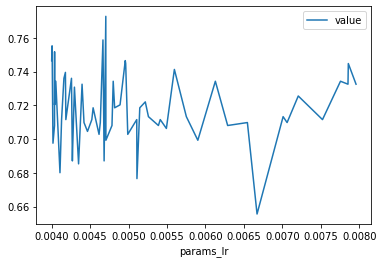

In [18]:
#df[['value', 'params_lr']].plot()
#df.plot(x='params_lr', y='value')
df.sort_values(by='params_lr', ascending=False).plot(x='params_lr', y='value')